In [165]:
%load_ext autoreload
%autoreload 2
%aimport pareto
from pareto import *
from functools import partial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [255]:
alpha = np.array([0.,0.])

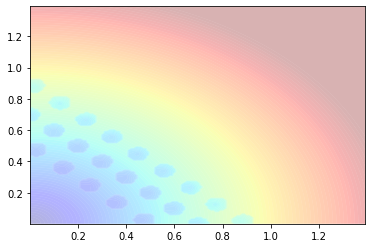

In [256]:
x, y = np.meshgrid(np.arange(0.001, 1.4, 0.01), np.arange(0.001, 1.4, 0.01))
loss_vec = jax.jit(jax.vmap(loss_moguls, in_axes=[0,None]))
z = loss_vec(np.stack((x.flatten(), y.flatten()), 1), alpha).reshape(x.shape)
plt.contourf(x, y, z, alpha=0.3, levels=np.linspace(0., 1.5, 100), cmap=plt.cm.jet, antialiased=True, extend='both')

In [26]:
INIT_POINT = (0.1, 1.7)

In [27]:
def get_paths_for_fixed_alpha(initialization, alpha, steps=3000):
  loss_vec = jax.jit(jax.vmap(loss_moguls, in_axes=[0,None]))
  loss_grad = jax.jit(jax.grad(loss_vec, argnums=[0]))

  def compute_next(xy, alpha):
    dxy = loss_grad(xy, alpha)
    xy = xy - 0.02 * dxy
    return xy

  compute_next_vec = jax.jit(jax.vmap(compute_next, in_axes=[0,None]))

  xs, ys = np.array([INIT_POINT for _ in ALPHAS]).T
  pathsx = [xs]
  pathsy = [ys]
  for gradient_step in range(steps):
    xs, ys = compute_next_vec(xs, ys, ALPHAS)
    pathsx.append(xs)
    pathsy.append(ys)
  pathsx = np.array(pathsx[0::20]).T
  pathsy = np.array(pathsy[0::20]).T
  
  #print(pathsy)
  return np.stack(loss_vec(pathsx, pathsy), 1)

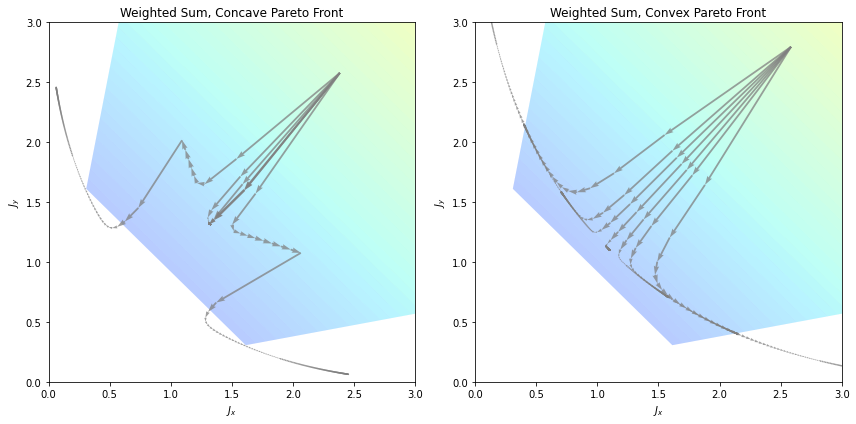

In [30]:
fig, anim = plot_paths([
  get_paths_for_sum(loss_concave), 
  get_paths_for_sum(loss_convex),
  #get_paths_for_lagrangian(loss_concave), 
  #get_paths_for_lagrangian(loss_convex),
  #get_paths_for_augmented_lagrangian(loss_concave), 
  #get_paths_for_augmented_lagrangian(loss_convex)
  ], titles = titles)

In [9]:
HTML(anim.to_html5_video())